# ANALISI

In [6]:
# !pip install -q scikit-learn pandas numpy matplotlib seaborn imbalanced-learn shap tensorflow


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight

import shap
import warnings, os, random
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED); random.seed(SEED)


c:\Users\laudi\OneDrive\Documenti\REPO\DeepLearning_MachineLearning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.copy()
df.head(3)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


In [28]:
df.columns = [c.strip().lower().replace('-', '_') for c in df.columns]
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.replace('?', np.nan)

target_col = 'class'  # etichetta originale
df[target_col].value_counts()


class
<=50K    37155
>50K     11687
Name: count, dtype: int64

## PULIZIA

In [29]:
# Categorical vs Numeric
cat_cols = df.select_dtypes(include='category').columns.tolist()
cat_cols.remove(target_col)
num_cols = df.select_dtypes(exclude='category').columns.tolist()

# Trasformiamo la target in binaria: >50K -> 1, altrimenti 0
df['income'] = (df[target_col] == '>50K').astype(int)
df = df.drop(columns=[target_col])

# Missing: imputazione semplice (moda per cat, mediana per num) – lo faremo nel pipeline
print("Shape:", df.shape)
print("Target rate (>50K):", df['income'].mean().round(3))


Shape: (48842, 15)
Target rate (>50K): 0.239


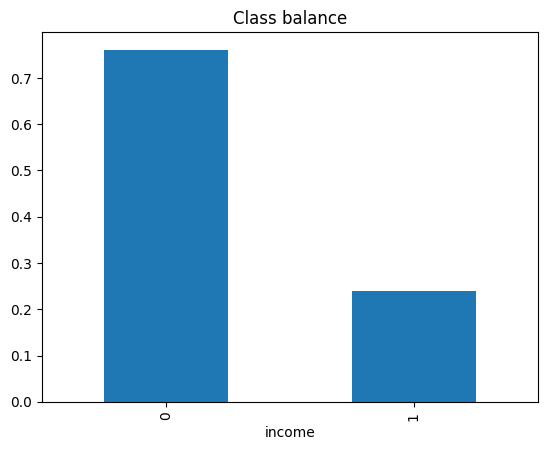

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.64,13.71,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.13,105604.03,12285.0,117550.5,178144.5,237642.0,1490400.0
education_num,48842.0,10.08,2.57,1.0,9.0,10.0,12.0,16.0
capital_gain,48842.0,1079.07,7452.02,0.0,0.0,0.0,0.0,99999.0
capital_loss,48842.0,87.50,403.00,0.0,0.0,0.0,0.0,4356.0
hours_per_week,48842.0,40.42,12.39,1.0,40.0,40.0,45.0,99.0


In [30]:
fig, ax = plt.subplots()
df['income'].value_counts(normalize=True).plot(kind='bar', ax=ax)
ax.set_title("Class balance")
plt.show()

df[num_cols].describe().T.round(2)


In [31]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

len(X_train), len(X_test), y_train.mean().round(3)


(39073, 9769, np.float64(0.239))

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),  # with_mean=False se sparse
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder='drop',
    sparse_threshold=0.3  # mantiene sparse se grande
)


In [37]:
baseline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print("Dummy accuracy:", (y_pred == y_test).mean().round(3))

logreg = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(logreg, X_train, y_train, scoring="average_precision", cv=cv)
print("LogReg CV PR-AUC (mean±std):", scores.mean().round(3), "±", scores.std().round(3))

logreg.fit(X_train, y_train)
proba = logreg.predict_proba(X_test)[:,1]
print("Test ROC-AUC:", round(roc_auc_score(y_test, proba), 3))
print("Test PR-AUC :", round(average_precision_score(y_test, proba), 3))


Dummy accuracy: 0.761
LogReg CV PR-AUC (mean±std): 0.766 ± 0.011
Test ROC-AUC: 0.906
Test PR-AUC : 0.767


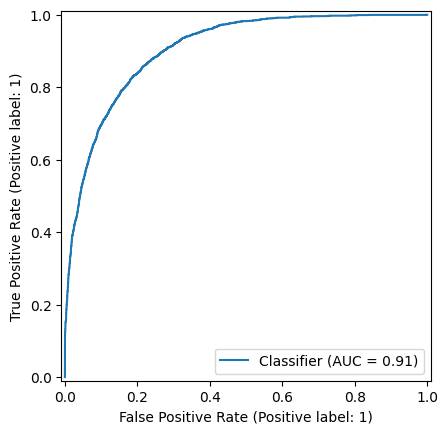

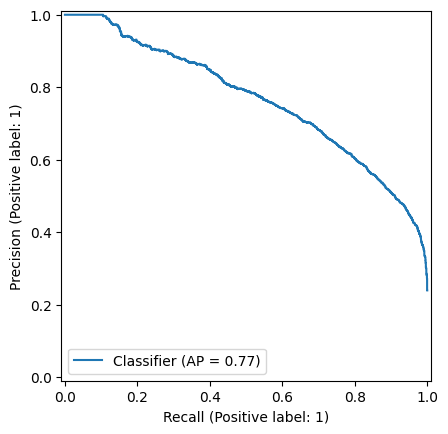

In [38]:
RocCurveDisplay.from_predictions(y_test, proba); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, proba); plt.show()


In [39]:
pred_05 = (proba >= 0.5).astype(int)
print(classification_report(y_test, pred_05, digits=3))
confusion_matrix(y_test, pred_05)


              precision    recall  f1-score   support

           0      0.881     0.935     0.907      7431
           1      0.742     0.597     0.662      2338

    accuracy                          0.854      9769
   macro avg      0.811     0.766     0.784      9769
weighted avg      0.847     0.854     0.848      9769



array([[6946,  485],
       [ 942, 1396]])

In [41]:
calibr = Pipeline([
    ("prep", preprocessor),
    ("clf", CalibratedClassifierCV(LogisticRegression(max_iter=2000), method="isotonic", cv=5))
])
calibr.fit(X_train, y_train)
p = calibr.predict_proba(X_test)[:,1]

# Ricerca soglia che massimizza F1
from sklearn.metrics import f1_score
ths = np.linspace(0.1, 0.9, 41)
f1s = [f1_score(y_test, (p>=t).astype(int)) for t in ths]
best_t = ths[int(np.argmax(f1s))]
best_t, max(f1s)


(np.float64(0.4), 0.6924887652471645)

In [45]:

from tensorflow import keras
from scipy import sparse

# Fit preprocessor una volta e trasformiamo
preprocessor.fit(X_train)
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)

# Densifichiamo (dimensioni gestibili per Adult)
Xtr = Xtr.toarray() if sparse.issparse(Xtr) else Xtr
Xte = Xte.toarray() if sparse.issparse(Xte) else Xte

input_dim = Xtr.shape[1]
pos_weight = compute_class_weight('balanced', classes=np.array([0,1]), y=y_train.values)
class_weight = {0: pos_weight[0], 1: pos_weight[1]}

model = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(curve='ROC', name='auc'),
                       keras.metrics.AUC(curve='PR', name='pr_auc')])

cb = [
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5),
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_pr_auc", mode="max")
]

hist = model.fit(
    Xtr, y_train.values,
    validation_split=0.2,
    epochs=50, batch_size=1024,
    callbacks=cb,
    class_weight=class_weight,
    verbose=0
)




AttributeError: 'float' object has no attribute 'round'

DL ROC-AUC: 0.9116914104198317
DL PR-AUC : 0.7802246993977315


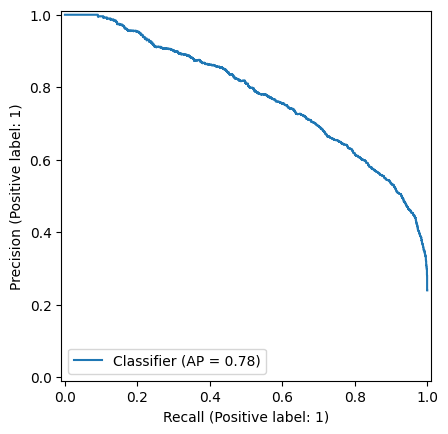

In [46]:
p_dl = model.predict(Xte, verbose=0).ravel()
print("DL ROC-AUC:", roc_auc_score(y_test, p_dl))
print("DL PR-AUC :", average_precision_score(y_test, p_dl))
PrecisionRecallDisplay.from_predictions(y_test, p_dl); plt.show()